In [35]:
import ssl
import torch
ssl._create_default_https_context = ssl._create_unverified_context
from torchvision import datasets
data_path = "./data/"
cifar10 = datasets.CIFAR10(data_path, train=True, download=True)
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True)


Files already downloaded and verified
Files already downloaded and verified


In [36]:
from torchvision import transforms
tensor_cifar10 = datasets.CIFAR10(data_path, train=True, download=False, transform=transforms.ToTensor())
imgs = torch.stack([img_t for img_t, _ in tensor_cifar10], dim=3)
imgs.shape
tensor_cifar10_val = datasets.CIFAR10(data_path, train=False, download=False, transform=transforms.ToTensor())
imgs_val = torch.stack([img_t for img_t, _ in tensor_cifar10_val], dim=3)
imgs_val.shape

torch.Size([3, 32, 32, 10000])

In [37]:
transforms.Normalize((0.4914, 0.4822, 0.4465),  (0.2470, 0.2435, 0.2616))

Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.2435, 0.2616))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


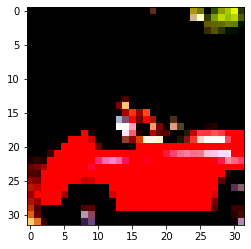

In [38]:
import matplotlib.pyplot as plt
transformed_cifar10 = datasets.CIFAR10(data_path, train=True, download=False, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465),  (0.2470, 0.2435, 0.2616))]))
img_t, _  = transformed_cifar10[99]
plt.imshow(img_t.permute(1, 2, 0))
plt.show()

In [39]:
transforms.Normalize((0.4942, 0.4851, 0.4504),  (0.2467, 0.2429, 0.2616))
val_transformed_cifar10 = datasets.CIFAR10(data_path, train=False, download=False, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465),  (0.2470, 0.2435, 0.2616))]))


In [40]:
import torch.nn.functional as F
import torch.nn as nn
class CNN(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=5):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * n_chans1, 32)
        self.fc2 = nn.Linear(32, 10)
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [41]:
import torch
device = torch.device('cuda:0')
train_loader = torch.utils.data.DataLoader(transformed_cifar10, batch_size=64, shuffle=True)

model = CNN()
model.to(device)
loss_function = nn.CrossEntropyLoss()
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [42]:
import time
def training(model, optimizer, loss_fn, n_epochs, device, train_loader):
    start = time.time()

    for epoch in range(n_epochs):
        for imgs, labels in train_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            batch_size = imgs.shape[0]
            outputs = model(imgs)
            loss = loss_fn((outputs), labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print("Epoch: %d, Loss: %f" % (epoch, float(loss)))
    end = time.time()
    print(end - start)

In [43]:
n_epochs = 300
training(model, optimizer, loss_function, n_epochs, device, train_loader)

Epoch: 0, Loss: 1.498447
Epoch: 1, Loss: 1.497896
Epoch: 2, Loss: 1.313029
Epoch: 3, Loss: 0.725449
Epoch: 4, Loss: 1.140860
Epoch: 5, Loss: 0.979368
Epoch: 6, Loss: 0.955193
Epoch: 7, Loss: 0.922603
Epoch: 8, Loss: 0.877520
Epoch: 9, Loss: 1.048637
Epoch: 10, Loss: 0.969260
Epoch: 11, Loss: 0.982045
Epoch: 12, Loss: 0.776672
Epoch: 13, Loss: 0.345156
Epoch: 14, Loss: 0.983632
Epoch: 15, Loss: 0.762592
Epoch: 16, Loss: 0.937057
Epoch: 17, Loss: 0.873066
Epoch: 18, Loss: 0.701364
Epoch: 19, Loss: 0.904475
Epoch: 20, Loss: 0.554761
Epoch: 21, Loss: 1.172717
Epoch: 22, Loss: 0.972105
Epoch: 23, Loss: 0.560831
Epoch: 24, Loss: 0.362465
Epoch: 25, Loss: 0.488543
Epoch: 26, Loss: 0.514368
Epoch: 27, Loss: 0.417470
Epoch: 28, Loss: 0.634012
Epoch: 29, Loss: 0.876366
Epoch: 30, Loss: 0.836783
Epoch: 31, Loss: 0.840493
Epoch: 32, Loss: 0.869559
Epoch: 33, Loss: 0.839005
Epoch: 34, Loss: 1.090934
Epoch: 35, Loss: 0.555672
Epoch: 36, Loss: 0.724887
Epoch: 37, Loss: 0.855388
Epoch: 38, Loss: 0.477

In [44]:
from ptflops import get_model_complexity_info


macs, params = get_model_complexity_info(model, ( 3, 32,32), as_strings=True, print_per_layer_stat=False, verbose=False)
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

Computational complexity:       0.0 GMac
Number of parameters:           76.04 k 


In [45]:
val_loader = torch.utils.data.DataLoader(val_transformed_cifar10, batch_size=64, shuffle=False)

correct = 0
total = 0
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        batch_size=imgs.shape[0]
        outputs = model(imgs)
        _, predicted = torch.max(outputs, dim=1)
#         print(predicted)
#         print("\n")
#         print(labels)
        total += labels.shape[0]
        correct += int((predicted==labels).sum())
    print("Accuracy ", correct/total)

Accuracy  0.6443


In [46]:
#Part 1b
import torch.nn.functional as F
class CNN2(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=5):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, 16, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(16, n_chans1, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * n_chans1, 32)
        self.fc2 = nn.Linear(32, 10)
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = F.max_pool2d(torch.tanh(self.conv3(out)), 2)
        out = out.view(-1, 4 * 4 * self.n_chans1)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [47]:
import torch
device = torch.device('cuda:0')
train_loader = torch.utils.data.DataLoader(transformed_cifar10, batch_size=64, shuffle=True)

model = CNN2()
model.to(device)
loss_function = nn.CrossEntropyLoss()
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [48]:
import time
def training(model, optimizer, loss_fn, n_epochs, device, train_loader):
    start = time.time()

    for epoch in range(n_epochs):
        for imgs, labels in train_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            
            batch_size = imgs.shape[0]
            outputs = model(imgs)
            loss = loss_fn((outputs), labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print("Epoch: %d, Loss: %f" % (epoch, float(loss)))
    end = time.time()
    print(end - start)

In [49]:
n_epochs = 300
training(model, optimizer, loss_function, n_epochs, device, train_loader)

Epoch: 0, Loss: 1.896323
Epoch: 1, Loss: 1.648372
Epoch: 2, Loss: 1.083320
Epoch: 3, Loss: 1.322986
Epoch: 4, Loss: 1.201101
Epoch: 5, Loss: 1.132529
Epoch: 6, Loss: 1.267703
Epoch: 7, Loss: 1.157219
Epoch: 8, Loss: 1.527774
Epoch: 9, Loss: 0.892078
Epoch: 10, Loss: 0.720922
Epoch: 11, Loss: 1.120539
Epoch: 12, Loss: 0.693970
Epoch: 13, Loss: 1.180377
Epoch: 14, Loss: 1.237997
Epoch: 15, Loss: 0.881170
Epoch: 16, Loss: 0.662154
Epoch: 17, Loss: 1.143472
Epoch: 18, Loss: 0.830828
Epoch: 19, Loss: 0.953425
Epoch: 20, Loss: 1.368803
Epoch: 21, Loss: 1.404832
Epoch: 22, Loss: 0.600543
Epoch: 23, Loss: 0.858952
Epoch: 24, Loss: 0.946415
Epoch: 25, Loss: 0.583561
Epoch: 26, Loss: 0.418478
Epoch: 27, Loss: 0.705524
Epoch: 28, Loss: 0.718551
Epoch: 29, Loss: 0.548431
Epoch: 30, Loss: 0.621175
Epoch: 31, Loss: 0.785009
Epoch: 32, Loss: 0.765577
Epoch: 33, Loss: 0.861708
Epoch: 34, Loss: 0.878913
Epoch: 35, Loss: 0.491723
Epoch: 36, Loss: 0.741196
Epoch: 37, Loss: 0.602203
Epoch: 38, Loss: 0.510

In [50]:
from ptflops import get_model_complexity_info


macs, params = get_model_complexity_info(model, ( 3, 32,32), as_strings=True, print_per_layer_stat=False, verbose=False)
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

Computational complexity:       0.0 GMac
Number of parameters:           26.91 k 


In [51]:
val_loader = torch.utils.data.DataLoader(val_transformed_cifar10, batch_size=64, shuffle=False)

correct = 0
total = 0
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        batch_size=imgs.shape[0]
        outputs = model(imgs)
        _, predicted = torch.max(outputs, dim=1)
#         print(predicted)
#         print("\n")
#         print(labels)
        total += labels.shape[0]
        correct += int((predicted==labels).sum())
    print("Accuracy ", correct/total)

Accuracy  0.6989


In [52]:
#Part 2
import torch.nn as nn
class ResBlock(nn.Module):
    def __init__(self, n_chans):
        super(ResBlock, self).__init__()
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3, padding=1, bias=False)
        self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
        torch.nn.init.kaiming_normal_(self.conv.weight, nonlinearity='relu')
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)
        
    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out
 


In [53]:
import torch.nn.functional as F
class ResNet10(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=10):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.ResNetBlocks = nn.Sequential(*(n_blocks * [ResBlock(n_chans=n_chans1)]))
        self.fc1 = nn.Linear(16 * 16 * n_chans1, 32)
        self.fc2 = nn.Linear(32, 10)
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.ResNetBlocks(out)
        out = out.view(-1, 16 * 16 * self.n_chans1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [54]:
import torch
device = torch.device('cuda:0')
train_loader = torch.utils.data.DataLoader(transformed_cifar10, batch_size=64, shuffle=True)

model = ResNet10()
model.to(device)
loss_function = nn.CrossEntropyLoss()
learning_rate = 3e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [55]:
n_epochs = 300
training(model, optimizer, loss_function, n_epochs, device, train_loader)

Epoch: 0, Loss: 1.380295
Epoch: 1, Loss: 1.534053
Epoch: 2, Loss: 1.522577
Epoch: 3, Loss: 1.108553
Epoch: 4, Loss: 0.830498
Epoch: 5, Loss: 1.134960
Epoch: 6, Loss: 0.875195
Epoch: 7, Loss: 0.962270
Epoch: 8, Loss: 0.826196
Epoch: 9, Loss: 0.816926
Epoch: 10, Loss: 0.934372
Epoch: 11, Loss: 1.005834
Epoch: 12, Loss: 1.560953
Epoch: 13, Loss: 0.384691
Epoch: 14, Loss: 1.155713
Epoch: 15, Loss: 0.883912
Epoch: 16, Loss: 0.866532
Epoch: 17, Loss: 0.759370
Epoch: 18, Loss: 0.868821
Epoch: 19, Loss: 0.997360
Epoch: 20, Loss: 0.648042
Epoch: 21, Loss: 0.841270
Epoch: 22, Loss: 0.368993
Epoch: 23, Loss: 0.815533
Epoch: 24, Loss: 0.946853
Epoch: 25, Loss: 0.451778
Epoch: 26, Loss: 0.729739
Epoch: 27, Loss: 0.728167
Epoch: 28, Loss: 0.459222
Epoch: 29, Loss: 0.848244
Epoch: 30, Loss: 0.874603
Epoch: 31, Loss: 0.883124
Epoch: 32, Loss: 0.394543
Epoch: 33, Loss: 0.528460
Epoch: 34, Loss: 0.280844
Epoch: 35, Loss: 0.585605
Epoch: 36, Loss: 0.984623
Epoch: 37, Loss: 0.662719
Epoch: 38, Loss: 0.800

In [56]:
from ptflops import get_model_complexity_info


macs, params = get_model_complexity_info(model, ( 3, 32,32), as_strings=True, print_per_layer_stat=False, verbose=False)
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

Computational complexity:       0.02 GMac
Number of parameters:           272.68 k


In [57]:
val_loader = torch.utils.data.DataLoader(val_transformed_cifar10, batch_size=64, shuffle=False)

correct = 0
total = 0
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        batch_size=imgs.shape[0]
        outputs = model(imgs)
        _, predicted = torch.max(outputs, dim=1)
#         print(predicted)
#         print("\n")
#         print(labels)
        total += labels.shape[0]
        correct += int((predicted==labels).sum())
    print("Accuracy ", correct/total)

Accuracy  0.1


In [58]:
#part 2B

import time
def training(model, optimizer, loss_fn, n_epochs, device, train_loader, l2_lambda):
    start = time.time()

    for epoch in range(n_epochs):
        for imgs, labels in train_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            
            batch_size = imgs.shape[0]
            outputs = model(imgs)
            loss = loss_fn((outputs), labels)
            l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
            loss = loss + l2_lambda* l2_norm
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print("Epoch: %d, Loss: %f" % (epoch, float(loss)))
    end = time.time()
    print(end - start)

In [59]:
n_epochs = 300
l2_lambda = .001
training(model, optimizer, loss_function, n_epochs, device, train_loader, l2_lambda)

Epoch: 0, Loss: 10.951440
Epoch: 1, Loss: 4.647394
Epoch: 2, Loss: 2.800955
Epoch: 3, Loss: 2.225659
Epoch: 4, Loss: 2.161125
Epoch: 5, Loss: 1.862766
Epoch: 6, Loss: 1.583517
Epoch: 7, Loss: 2.222004
Epoch: 8, Loss: 1.820010
Epoch: 9, Loss: 1.967250
Epoch: 10, Loss: 2.207386
Epoch: 11, Loss: 1.357456
Epoch: 12, Loss: 1.738413
Epoch: 13, Loss: 1.820579
Epoch: 14, Loss: 1.710661
Epoch: 15, Loss: 1.451937
Epoch: 16, Loss: 1.800370
Epoch: 17, Loss: 1.454486
Epoch: 18, Loss: 1.609495
Epoch: 19, Loss: 1.340552
Epoch: 20, Loss: 1.648403
Epoch: 21, Loss: 1.213099
Epoch: 22, Loss: 1.931675
Epoch: 23, Loss: 1.811163
Epoch: 24, Loss: 1.763996
Epoch: 25, Loss: 1.617107
Epoch: 26, Loss: 1.084703
Epoch: 27, Loss: 1.235137
Epoch: 28, Loss: 1.430830
Epoch: 29, Loss: 2.334033
Epoch: 30, Loss: 1.967194
Epoch: 31, Loss: 1.908156
Epoch: 32, Loss: 1.707417
Epoch: 33, Loss: 1.488826
Epoch: 34, Loss: 1.145470
Epoch: 35, Loss: 1.285830
Epoch: 36, Loss: 1.456136
Epoch: 37, Loss: 1.784907
Epoch: 38, Loss: 1.52

In [60]:
from ptflops import get_model_complexity_info


macs, params = get_model_complexity_info(model, ( 3, 32,32), as_strings=True, print_per_layer_stat=False, verbose=False)
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

Computational complexity:       0.02 GMac
Number of parameters:           272.68 k


In [61]:
val_loader = torch.utils.data.DataLoader(val_transformed_cifar10, batch_size=64, shuffle=False)

correct = 0
total = 0
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        batch_size=imgs.shape[0]
        outputs = model(imgs)
        _, predicted = torch.max(outputs, dim=1)
#         print(predicted)
#         print("\n")
#         print(labels)
        total += labels.shape[0]
        correct += int((predicted==labels).sum())
    print("Accuracy ", correct/total)

Accuracy  0.5052


In [62]:
import torch.nn.functional as F
class ResNet10(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=10):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_dropout = nn.Dropout2d(p=0.3)
        self.ResNetBlocks = nn.Sequential(*(n_blocks * [ResBlock(n_chans=n_chans1)]))
        self.fc1 = nn.Linear(16 * 16 * n_chans1, 32)
        self.fc2 = nn.Linear(32, 10)
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.conv1_dropout(out)
        out = self.ResNetBlocks(out)
        out = out.view(-1, 16 * 16 * self.n_chans1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [63]:
import torch
device = torch.device('cuda:0')
train_loader = torch.utils.data.DataLoader(transformed_cifar10, batch_size=64, shuffle=True)

model = ResNet10()
model.to(device)
loss_function = nn.CrossEntropyLoss()
learning_rate = 3e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [64]:
n_epochs = 300
l2_lambda = .001
training(model, optimizer, loss_function, n_epochs, device, train_loader, l2_lambda)

Epoch: 0, Loss: 2.109835
Epoch: 1, Loss: 1.969299
Epoch: 2, Loss: 1.010406
Epoch: 3, Loss: 1.695881
Epoch: 4, Loss: 1.560346
Epoch: 5, Loss: 1.402911
Epoch: 6, Loss: 0.806718
Epoch: 7, Loss: 1.900599
Epoch: 8, Loss: 1.594776
Epoch: 9, Loss: 1.694569
Epoch: 10, Loss: 1.355907
Epoch: 11, Loss: 1.411947
Epoch: 12, Loss: 1.280041
Epoch: 13, Loss: 1.848790
Epoch: 14, Loss: 1.218277
Epoch: 15, Loss: 1.878471
Epoch: 16, Loss: 1.468370
Epoch: 17, Loss: 1.517360
Epoch: 18, Loss: 0.981155
Epoch: 19, Loss: 1.447148
Epoch: 20, Loss: 1.244213
Epoch: 21, Loss: 1.141342
Epoch: 22, Loss: 1.386391
Epoch: 23, Loss: 1.805052
Epoch: 24, Loss: 1.588807
Epoch: 25, Loss: 2.014440
Epoch: 26, Loss: 1.912367
Epoch: 27, Loss: 1.130355
Epoch: 28, Loss: 1.580149
Epoch: 29, Loss: 1.610882
Epoch: 30, Loss: 1.176360
Epoch: 31, Loss: 1.310100
Epoch: 32, Loss: 1.648198
Epoch: 33, Loss: 1.367503
Epoch: 34, Loss: 1.422516
Epoch: 35, Loss: 1.680829
Epoch: 36, Loss: 1.376226
Epoch: 37, Loss: 1.313788
Epoch: 38, Loss: 1.669

In [65]:
from ptflops import get_model_complexity_info


macs, params = get_model_complexity_info(model, ( 3, 32,32), as_strings=True, print_per_layer_stat=False, verbose=False)
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

Computational complexity:       0.02 GMac
Number of parameters:           272.68 k


In [66]:
val_loader = torch.utils.data.DataLoader(val_transformed_cifar10, batch_size=64, shuffle=False)

correct = 0
total = 0
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        batch_size=imgs.shape[0]
        outputs = model(imgs)
        _, predicted = torch.max(outputs, dim=1)
#         print(predicted)
#         print("\n")
#         print(labels)
        total += labels.shape[0]
        correct += int((predicted==labels).sum())
    print("Accuracy ", correct/total)

Accuracy  0.3615
